In [1]:
import jax.numpy as np
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import lineax
import jax
import optax
import optimistix

from make_pulse_and_trace import MakePulse, apply_noise

from utilities import MyNamespace

In [2]:
pulse_maker=MakePulse(N=128*10, Deltaf=4) # Deltaf should be 3 for thg and 2 for shg -> depends on central_f is guess, currently 0.5
# ifrog -> Deltaf controls temporal resolution and needs to be sufficiently large 


pulse_maker.multi_pulse_time_domain_length_multiplier=8
pulse_maker.multi_pulse_parameters=[[50, 50], [5, 5, 5], [0.5, 0.25, 0.25], [1, 1, 1], ["flat", "flat", "flat"], [None, None, None]] 

time_inp, pulse_t_inp, frequency_inp, pulse_f_inp=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.3, 0.1], type="polynomial", parameters_phase=[1/4,0,0,1500,0], 
                                                                               multi_pulse_parameters=None)#pulse_maker.multi_pulse_parameters)

input_pulses=pulse_maker.input_pulses





time_gate, pulse_t_gate, frequency_gate, pulse_f_gate=pulse_maker.generate_pulse_t(spectral_amp_parameters=[0.45,0.05], type="polynomial", parameters_phase=[3/4,0,0,0], 
                                                                                   multi_pulse_parameters=None)

input_pulses_gate=pulse_maker.input_pulses

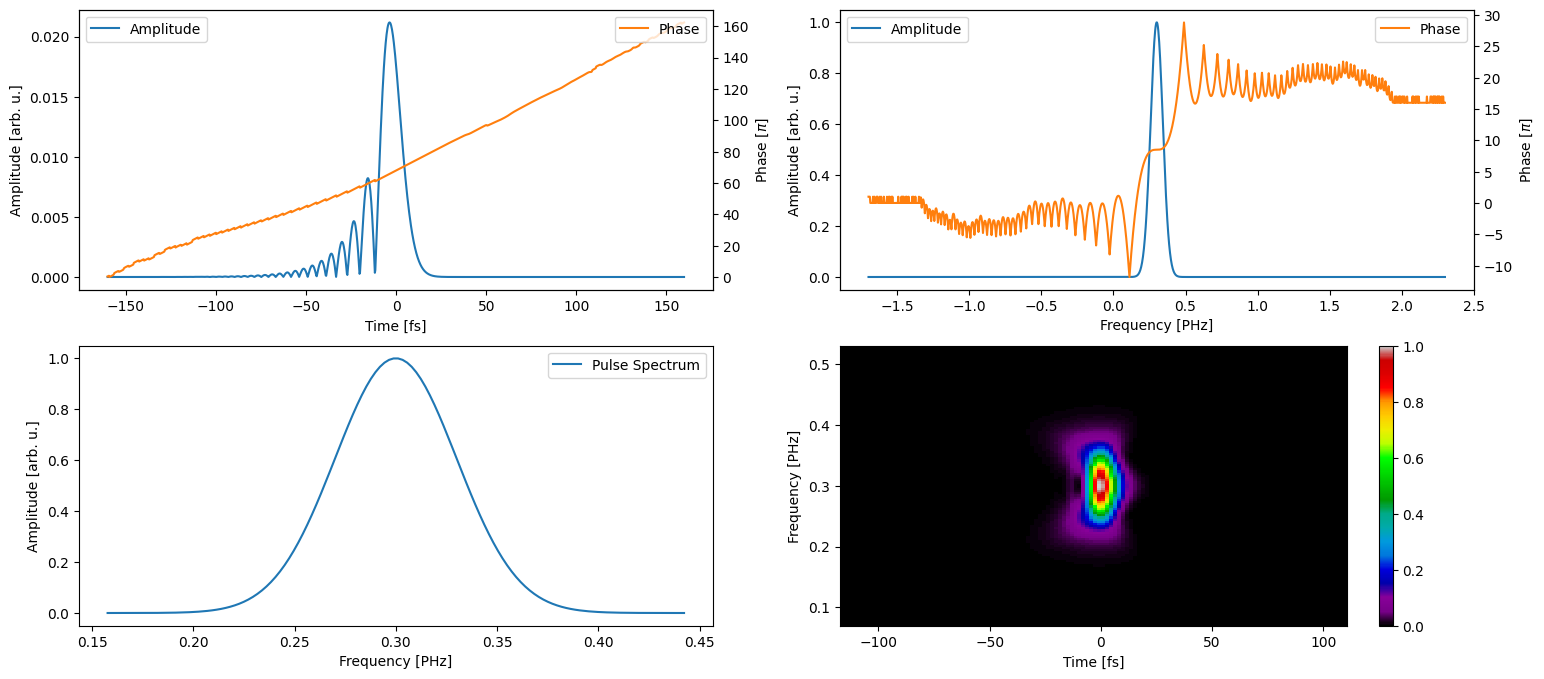

In [3]:
time, frequency, trace, spectra=pulse_maker.generate_frog_trace_and_spectrum(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, nonlinear_method="pg", 
                                                                                                  scale_time_range=5, N=128, xfrog=False, 
                                                                                                  gate=(frequency_gate, pulse_f_gate),
                                                                                                  interpolate_fft_conform=False, cut_off_val=1e-2,
                                                                                                  ifrog=False)#, frequency_range=(0,1))

#trace = apply_noise(trace, scale_val=(0.05, 0.05), additive_noise=True, multiplicative_noise=True)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


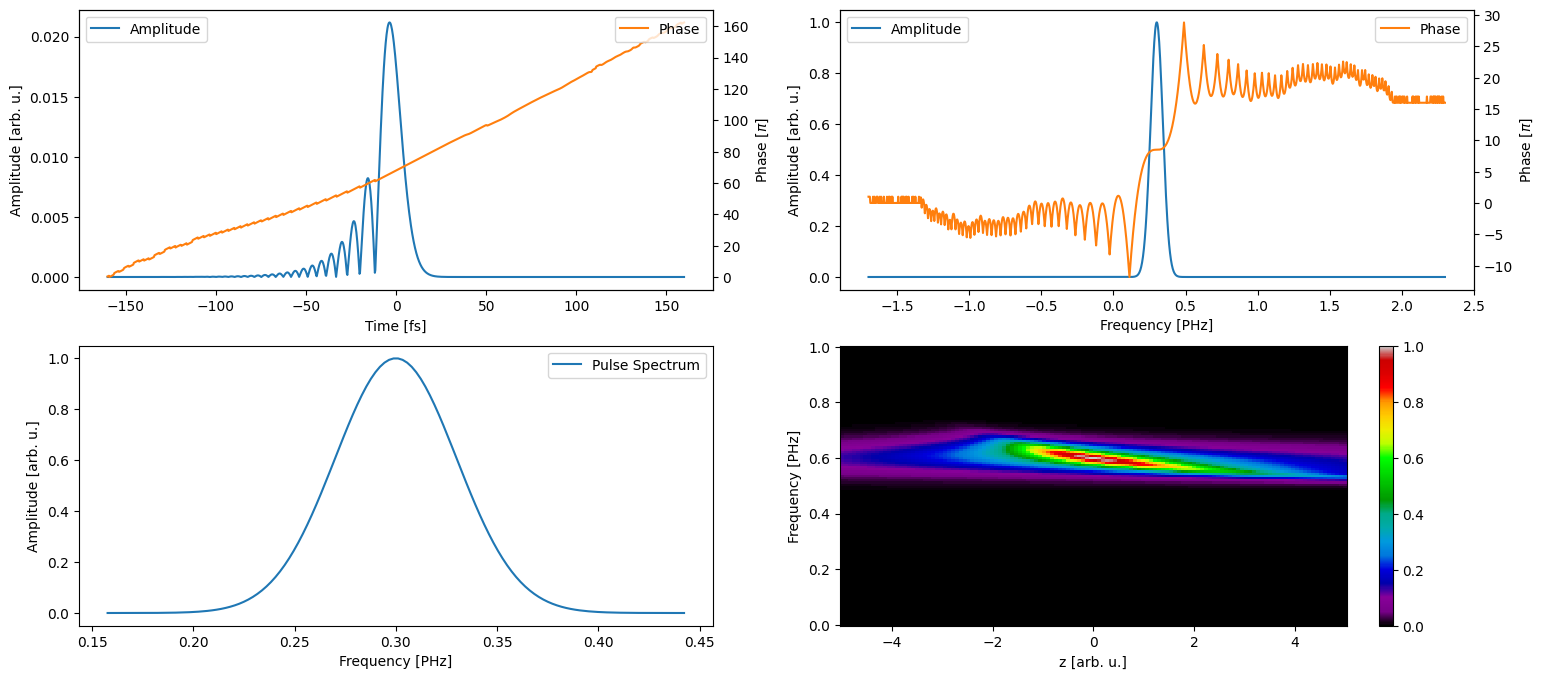

In [3]:
z_arr=np.linspace(-5, 5, 128)
#pulse_t, pulse_f=pulse_maker.precompensate_pulse_for_dscan(time, frequency, pulse_t, GDD=-5000, TOD=0, central_f=0.5)
frequency, trace, spectra = pulse_maker.generate_dscan_trace_and_spectrum(z_arr, time_inp, frequency_inp, pulse_t_inp, pulse_f_inp,
                                                                                                   nonlinear_method="shg", 
                                                                                                   N=128, cut_off_val=1e-3, frequency_range=(0,1))


#trace = apply_noise(trace, scale_val=0.01, additive_noise=True, multiplicative_noise=False)

# if there are weird stripes in the trace -> set Deltaf=2 somehow thats needed

In [11]:
from classic_algorithms_frog import Vanilla, LSGPA, GeneralizedProjection, TimeDomainPtychography, COPRA

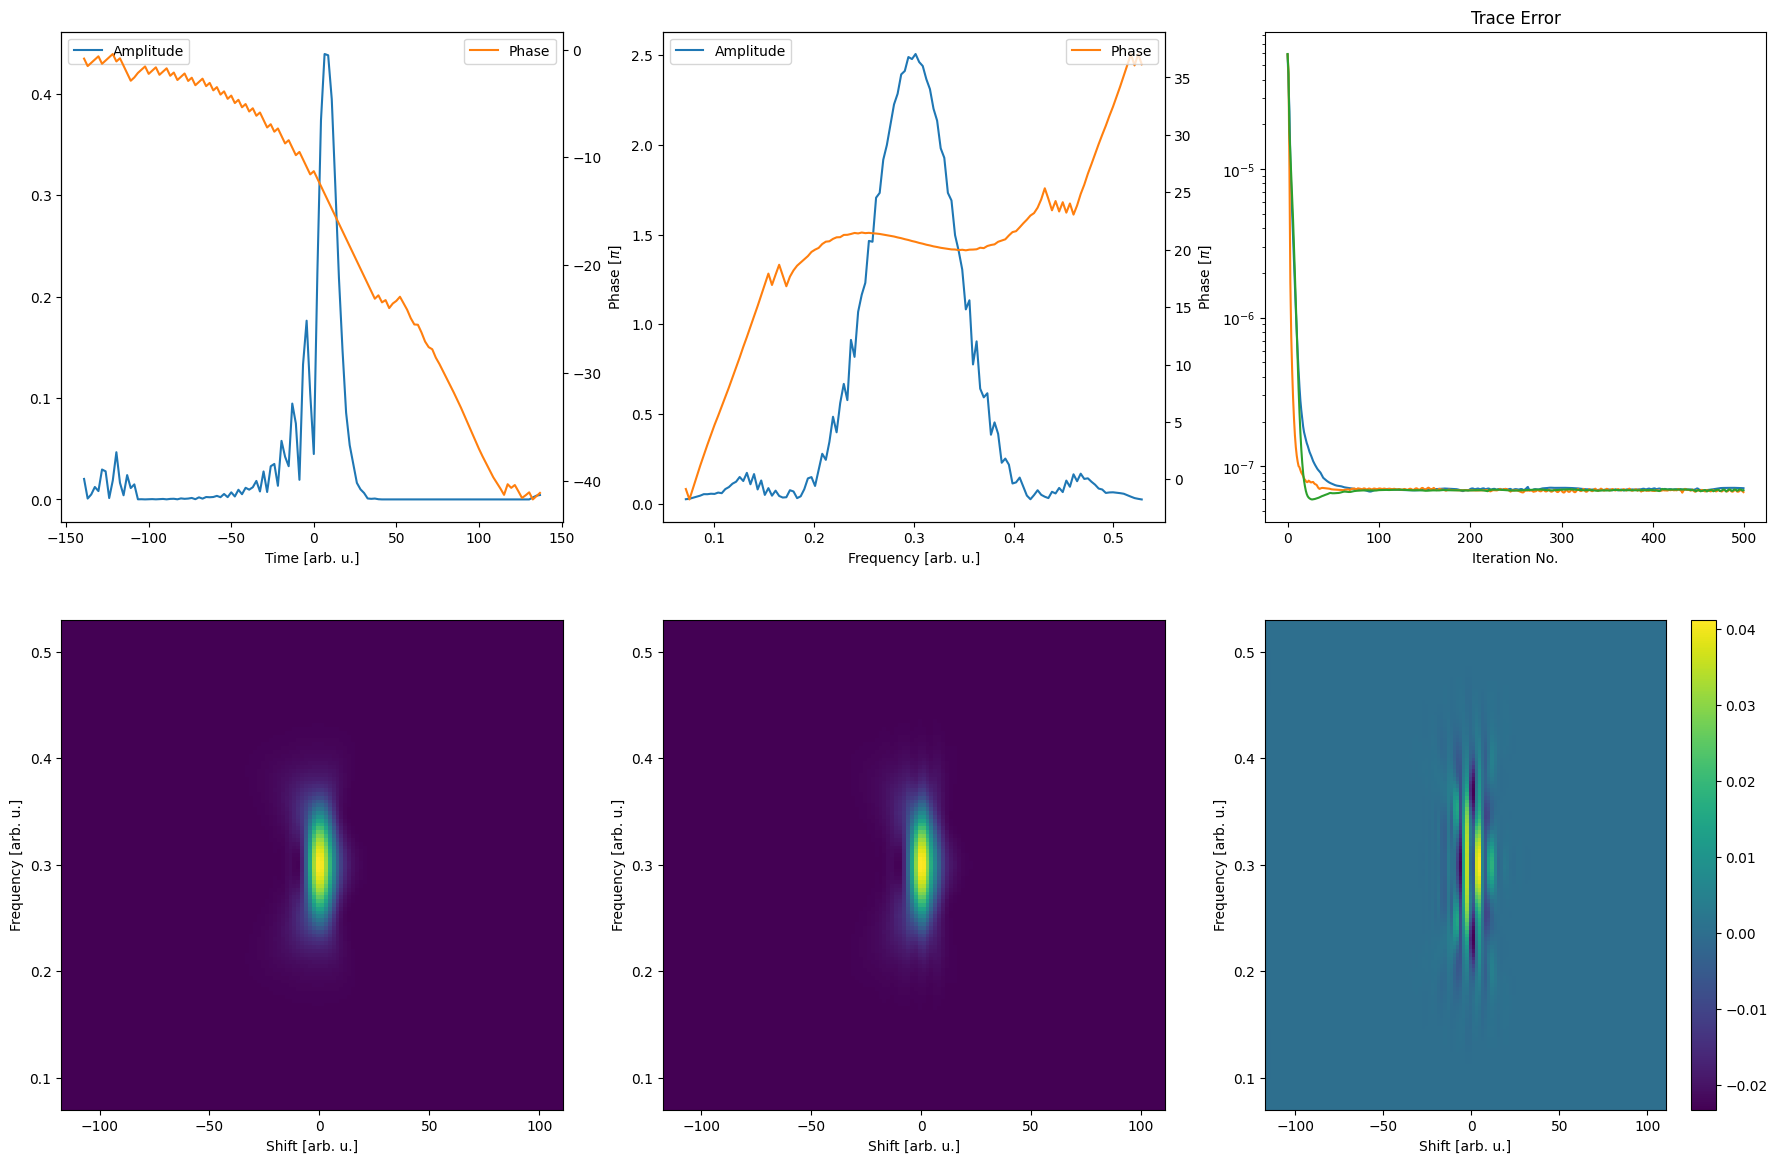

In [12]:
# vanilla = Vanilla(time, frequency, trace, "shg")
# population = vanilla.create_initial_population(population_size=3, guess_type="random")

# final_result = vanilla.run(population, 100)
# vanilla.plot_results(final_result)






lsgpa = LSGPA(time, frequency, trace, "pg", xfrog=False)#.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
population = lsgpa.create_initial_population(population_size=3, guess_type="random")

final_result = lsgpa.run(population, 500)
lsgpa.plot_results(final_result)






# gp = GeneralizedProjection(time, frequency, trace, "shg")#, xfrog="doubleblind")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# gp.use_hessian = False#"diagonal"#"lbfgs"
# gp.use_conjugate_gradients=False


# # gp.no_steps_descent = 25
# # gp.max_steps_linesearch = 25
# gp.use_linesearch = "backtracking"
# gp.gamma = 10
# # gp.delta_gamma = (0.5, 1.1)
# # gp.c1 = 1e-4
# # gp.c2 = 0.9

# # gp.lbfgs_memory = 3

# # gp.use_copra_style_step_scaling = False


# final_result = gp.run(population, 15)
# gp.plot_results(final_result)






# tdp = TimeDomainPtychography(time, frequency, trace, "pg", "ePIE", xfrog=False)
# population = tdp.create_initial_population(population_size=3, guess_type="random")

# tdp.alpha = 0.1
# tdp.gamma = 0.1

# tdp.lbfgs_memory = 15
# tdp.use_conjugate_gradients = False#"fletcher_reeves"

# tdp.use_hessian = False
# tdp.use_linesearch = False#"backtracking"

# final_result = tdp.run(population, 10, 10)
# tdp.plot_results(final_result)






# copra = COPRA(time, frequency, trace, "shg", ifrog=True, xfrog="doubleblind")
# population = copra.create_initial_population(population_size=3, guess_type="random")
# #copra.use_linesearch = "backtracking"
# copra.beta=1
# copra.gamma=0.25
# copra.xi=1e-6
# copra.use_hessian=False #"diagonal"
# final_result = copra.run(population, 50, 500)
# copra.plot_results(final_result)


In [4]:
from classic_algorithms_dscan import Basic, GeneralizedProjection, TimeDomainPtychography, COPRA

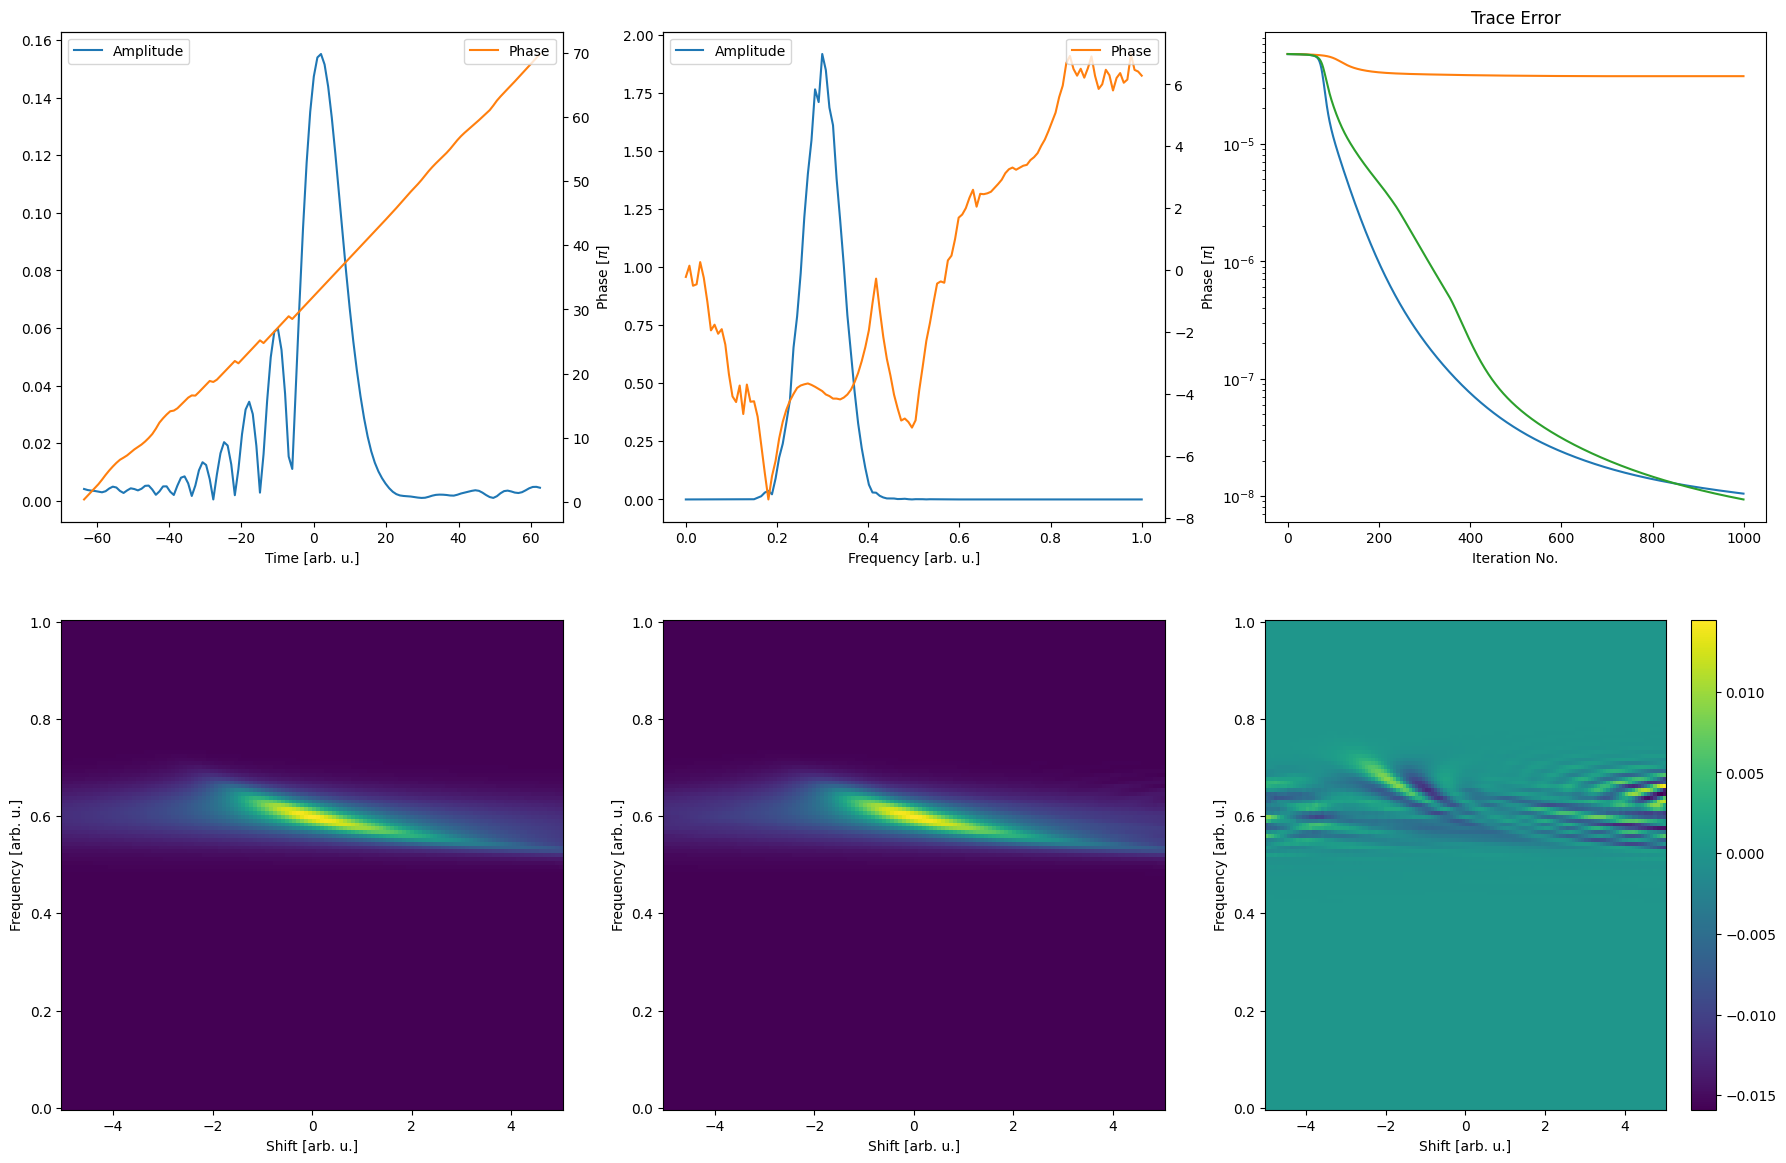

In [8]:
# basic = Basic(z_arr, frequency, trace, "shg")
# population = basic.create_initial_population(population_size=3, guess_type="random")

# final_result = basic.run(population, 100)
# basic.plot_results(final_result)





# gp = GeneralizedProjection(z_arr, frequency, trace, "shg")
# population = gp.create_initial_population(population_size=3, guess_type="random")

# gp.use_hessian="diagonal"
# gp.no_steps_descent=50
# gp.gamma=1e2

# final_result = gp.run(population, 100)
# gp.plot_results(final_result)




tdp = TimeDomainPtychography(z_arr, frequency, trace, "shg", pie_method="rPIE")
population = tdp.create_initial_population(population_size=3, guess_type="random")

tdp.alpha=0.1
tdp.gamma=0.0001

tdp.use_linesearch=False
tdp.use_hessian=False#"diagonal"

final_result = tdp.run(population, 0, 1000)
tdp.plot_results(final_result)






# copra = COPRA(z_arr, frequency, trace, "shg")
# population = copra.create_initial_population(population_size=3, guess_type="random")

# copra.beta = 1e1
# copra.gamma = 0.1
# copra.use_hessian = False, "diagonal"

# final_result = copra.run(population, 50, 200)
# copra.plot_results(final_result)

In [4]:
from general_algorithms_frog_real_fields import DifferentialEvolution, Evosax, LSF, AutoDiff

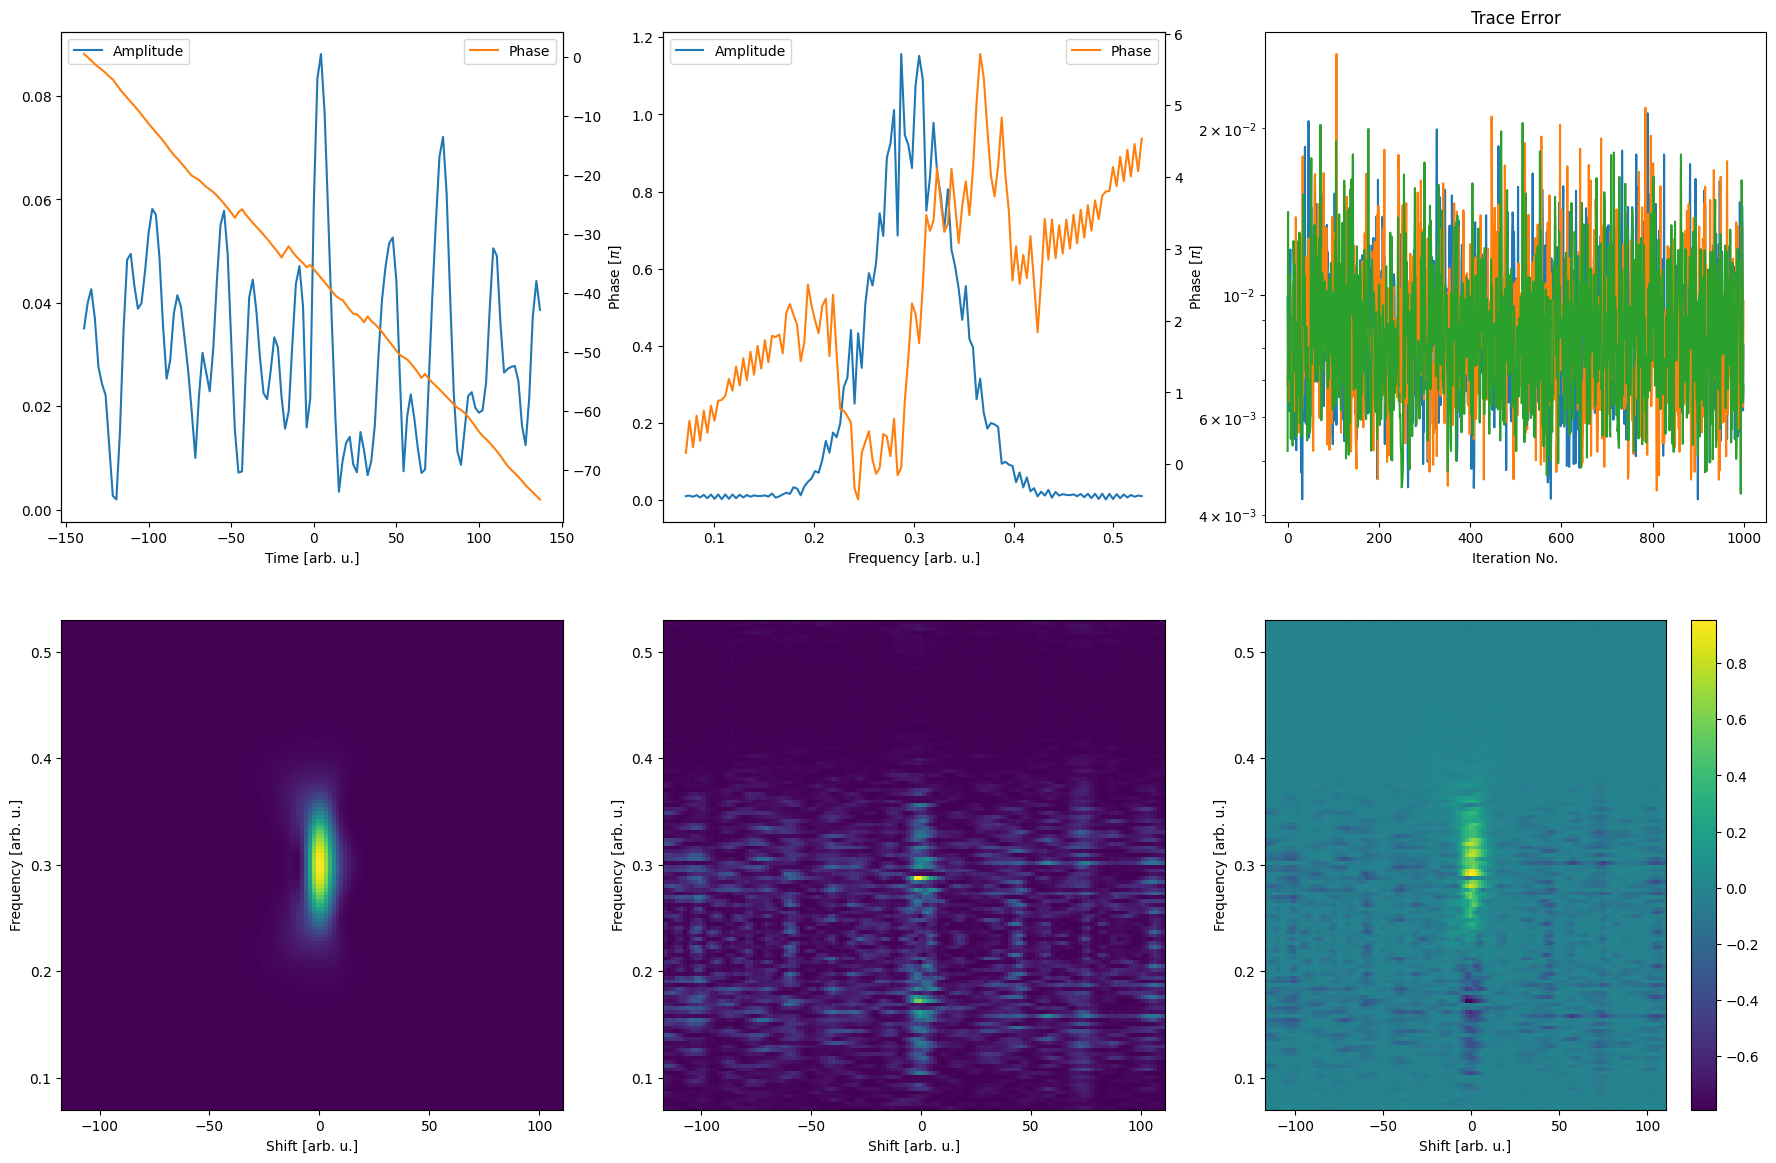

In [5]:
# de = DifferentialEvolution(time, frequency, trace, "pg", xfrog="doubleblind").use_measured_spectrum()
# spectral_amplitude = de.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = de.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = de.create_initial_population(population_size=250, amp_type="splines", phase_type="splines")

# de.strategy="best1_smooth"

# final_result = de.run(population, 150)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(time, frequency, trace, "pg", xfrog="doubleblind").use_measured_spectrum()
# spectral_amplitude = evo.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = evo.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = evo.create_initial_population(population_size=250)

# evo.solver = CMA_ES

# final_result = evo.run(population, 250)
# evo.plot_results(final_result)




lsf = LSF(time, frequency, trace, "pg", xfrog=False).use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")

population = lsf.create_initial_population(population_size=3, amp_type="discrete", phase_type="discrete")

lsf.number_of_bisection_iterations=12
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=5

final_result = lsf.run(population, 1000)
lsf.plot_results(final_result)





# ad = AutoDiff(time, frequency, trace, "thg", xfrog="doubleblind").use_measured_spectrum()

# spectral_amplitude = ad.get_spectral_amplitude(spectra.pulse[0], spectra.pulse[1], "pulse")
# spectral_amplitude = ad.get_spectral_amplitude(spectra.gate[0], spectra.gate[1], "gate")

# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.alternating_optimization = True
# ad.solver = optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)

In [8]:
error_arr = jnp.copy(final_result.error_arr)

In [12]:
error_arr_rand_phase = jnp.copy(final_result.error_arr)

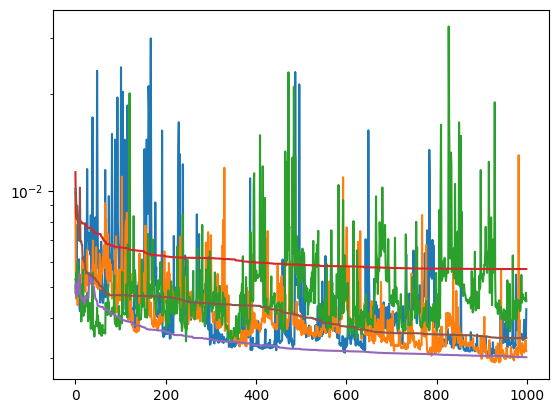

In [14]:
plt.plot(error_arr)
plt.plot(final_result.error_arr)
plt.yscale("log")

In [ ]:
from general_algorithms_dscan import DifferentialEvolution, Evosax, LSF, AutoGrad

In [ ]:
# de = DifferentialEvolution(z_arr, frequency, trace, "shg")
# population = de.create_initial_population(population_size=150)

# final_result = de.run(population, 100)
# de.plot_results(final_result)




# from evosax.algorithms import CMA_ES
# evo = Evosax(z_arr, frequency, trace, "shg")
# evo.solver = CMA_ES
# population = evo.create_initial_population(population_size=250)

# final_result = evo.run(population, 100)
# evo.plot_results(final_result)




lsf = LSF(z_arr, frequency, trace, "shg")
population = lsf.create_initial_population(population_size=3, amp_type="random", phase_type="random")

lsf.number_of_bisection_iterations=8
lsf.random_direction_mode="random"
lsf.no_points_for_continuous=15

final_result = lsf.run(population, 2000)
lsf.plot_results(final_result)





# ad = AutoGrad(z_arr, frequency, trace, "shg")
# population = ad.create_initial_population(population_size=1, amp_type="discrete", phase_type="discrete")

# ad.solver=optax.adam(learning_rate=1e-1)

# final_result = ad.run(population, 1000)
# ad.plot_results(final_result)